In [3]:
import json
import logging
import io
import boto3
import pandas as pd
import openpyxl
import spacy
import sklearn
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Modify pandas settings so print statements for debugging will not be truncated
pd.set_option("display.max_colwidth", 1000)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)

def file_downloader(bucket_name, file_key_attribute):
    '''
    Download the file into an object from the bucket name and file key
    
    Parameters:
        bucket_name (str): The S3 bucket name from where the file will be downloaded.
        file_key_attribute (str): The file key directing to the location of the file within the S3 bucket.
    
    Returns:
        body (obj): An IO file object containing the data from the file downloaded.
    '''
    s3 = boto3.client('s3')
    # Download the files to a temporary location
    obj = s3.get_object(Bucket=bucket_name, Key=file_key_attribute)
    body = obj['Body'].read()
    logging.info("Body and obj loaded in")
    return body

def sheet_name_grabber(iofile):
    '''
    Read the bytes file into a spreadsheet and extract the sheet names
    
    Parameters:
        iofile (obj): An IO file object containing the data from the file downloaded.
    
    Returns:
        attribute_ex (obj): The loaded workbook object.
        sheet_names_attribute (list): The list of sheet names extracted from the workbook.
    '''
    attribute_ex = openpyxl.load_workbook(io.BytesIO(iofile), data_only=True)
    logging.info("The workbook has been loaded into attribute_ex")
    sheet_names_attribute = attribute_ex.sheetnames
    logging.info(f"The list of sheet names is: {sheet_names_attribute}")
    return attribute_ex, sheet_names_attribute

def df_maker(workbook, sheetnamelist):
    '''
    Create a list of dataframes, one dataframe for each "Table" in the spreadsheet
    
    Parameters:
        workbook (obj): The loaded workbook object.
        sheetnamelist (list): The list of sheet names extracted from the workbook.
    
    Returns:
        dflist (list): The list of dataframes, one for each "Table" in the spreadsheet.
    '''
    # Create a list for the titles and a list for the tags
    titleslist = []
    tagslist = []
    dflist = []
    for sheet_name in sheetnamelist:
        if 'Table' in sheet_name:
            ws = workbook[sheet_name]
            sheet_name = pd.DataFrame(ws.values)
            dflist.append(sheet_name)
    return dflist

def df_header_fixer(df):
    '''
    Take a dataframe and move the column names to their appropriate location
    
    Parameters:
        df (DataFrame): The dataframe to fix the column names.
    
    Returns:
        df (DataFrame): The dataframe with fixed column names.
    '''
    # Fix column names
    df = df.rename(columns=df.iloc[2]).loc[3:]
    return df

def df_trunkater(df):
    '''
    Eliminate empty rows and fix indices for a dataframe
    
    Parameters:
        df (DataFrame): The dataframe to eliminate empty rows and fix indices.
    
    Returns:
        df (DataFrame): The dataframe with eliminated empty rows and fixed indices.
    '''
    df = df[df['Attribute_Name'].notna()]
    df.index = np.arange(len(df))
    return df

def desc_filler(df):
    '''
    Fill empty description cells in a dataframe
    
    Parameters:
        df (DataFrame): The dataframe to fill empty description cells.
    
    Returns:
        df (DataFrame): The dataframe with filled empty description cells.
    '''
    df = df[df['Attribute_Name'].notna()]
    df['Description'].fillna(df['Attribute_Name'], inplace=True)
    return df


In [4]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
import seaborn as sns

# These functions are used to create word vectors for the data, including tf-idf vectorization

# Create our list of stopwords
nlp = spacy.load("en_core_web_md")

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Basic function to clean the text
def clean_text(text):
    '''
    Remove spaces and convert text into lowercase
    
    Parameters:
        text (str): The input text to be cleaned.
    
    Returns:
        str: The cleaned text.
    '''
    return text.strip().lower()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    '''
    Tokenize a sentence using spaCy, performing lemmatization, lowercase conversion, and removing stop words.
    
    Parameters:
        sentence (str): The input sentence to be tokenized.
    
    Returns:
        list: The list of tokens.
    '''
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    
    # Lemmatizing each token and converting each token into lowercase
    for word in mytokens:
        if word.lemma_ != "-PRON-":
            word.lemma_.lower().strip()
        else:
            word = word.lower_
    
    # Removing stop words and punctuation
    mytokens = [word for word in mytokens if word not in STOP_WORDS and not word.is_punct]

    # Return preprocessed list of tokens
    return mytokens

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        '''
        Transform the input X by cleaning the text.
        
        Parameters:
            X (list): The input list of texts to be transformed.
        
        Returns:
            list: The transformed list of cleaned texts.
        '''
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        '''
        Fit the transformer.
        
        Parameters:
            X (list): The input list of texts.
            y: Ignored parameter.
        
        Returns:
            self: The fitted transformer object.
        '''
        return self

    def get_params(self, deep=True):
        '''
        Get parameters for the transformer.
        
        Parameters:
            deep: Ignored parameter.
        
        Returns:
            dict: The parameters of the transformer.
        '''
        return {}

def cleaner(df):
    '''
    Clean the 'Description' column in the dataframe by applying the clean_text function.
    
    Parameters:
        df (DataFrame): The input dataframe.
    
    Returns:
        DataFrame: The dataframe with the 'Cleaned_Text' column added.
    '''
    df['Cleaned_Text'] = df['Description'].apply(clean_text)
    return df

tfidf_vector = sklearn.feature_extraction.text.TfidfVectorizer()

def pcareducer(X):
    '''
    Reduce the dimensionality of the input data using PCA.
    
    Parameters:
        X (array-like): The input data to be reduced.
    
    Returns:
        array-like: The reduced data.
    '''
    pca = PCA(n_components=0.95, random_state=42)
    X_reduced = pca.fit_transform(X.toarray())
    return X_reduced

def vectorizer(df):
    '''
    Vectorize the 'Cleaned_Text' column of the dataframe using TF-IDF vectorization.
    
    Parameters:
        df (DataFrame): The input dataframe.
    
    Returns:
        array-like: The vectorized data.
    '''
    X = df['Cleaned_Text']
    X = tfidf_vector.fit_transform(X)
    return X

def bestwordsfinder(X):
    '''
    Find the words with TF-IDF values >= threshold from the vectorized data.
    
    Parameters:
        X (array-like): The vectorized data.
    
    Returns:
        DataFrame: The dataframe containing the words and their TF-IDF scores.
    '''
    feature_names = tfidf_vector.get_feature_names_out()
    goodwords = []
    goodvals = []
    
    for row in range(X.shape[0]):  # Iterate over each row in the matrix
        for col in X[row, :].nonzero()[1]:  # Get the indices of non-zero elements in the row
            word = feature_names[col]
            if word not in goodwords:
                goodwords.append(word)
                goodvals.append(X[row, col])
          
    tagsdf = pd.DataFrame(data={'Word': goodwords, 'tf-idf_score': goodvals})
    return tagsdf


In [5]:
'''The following functions are used for the clusterer'''

def km_clusterer(X):
    '''
    Create elbow plots testing different k's for each data set
    
    Parameters:
        X (array-like): The input data to create elbow plots.
    '''
    distortions = []    
    K = range(2, 30)
    for k in K:
        k_means = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
        k_means.fit(X)
        distortions.append(sum(np.min(cdist(X, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    X_line = [K[0], K[-1]]
    Y_line = [distortions[0], distortions[-1]]

    # Plot the elbow
    plt.plot(K, distortions, 'b-')
    plt.plot(X_line, Y_line, 'r')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title(f'The Elbow Method showing the optimal k')
    plt.show()

def kmeansfunc(df, vec):
    '''
    Create K-means cluster labels for a table
    
    Parameters:
        df (DataFrame): The input dataframe.
        vec (array-like): The input vector.
    
    Returns:
        DataFrame: The dataframe with cluster labels added.
    '''
    k = 3
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    y_pred = kmeans.fit_predict(vec)
    df['y'] = y_pred
    return df

def tsne_transformer(vector):
    '''
    Perform t-SNE transformation on a vector
    
    Parameters:
        vector (array-like): The input vector.
    
    Returns:
        array-like: The transformed vector.
    '''
    tsne = TSNE(verbose=1, perplexity=20) 
    vector = tsne.fit_transform(vector)

    return vector

def kmeans_plotter(df, vec):
    '''
    Create a scatterplot of the t-SNE'd data with labels
    
    Parameters:
        df (DataFrame): The input dataframe.
        vec (array-like): The input vector.
    '''
    X_embedded = vec
    y_pred = df['y']

    # sns settings
    sns.set(rc={'figure.figsize': (13, 9)})

    # colors
    palette = sns.hls_palette(20, l=.4, s=.9)

    # plot
    sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred, legend='full', palette=palette)
    plt.title('t-SNE with Kmeans Labels')
    plt.savefig("improved_cluster_tsne.png")
    plt.show()
    
def vectorizer_lister(df, cluster_count):
    '''
    Create a list of vectorizers for a dataframe, one for each cluster
    
    Parameters:
        df (DataFrame): The input dataframe.
        cluster_count (int): The number of clusters.
    
    Returns:
        list: The list of vectorizers.
    '''
    vectorizers = []
    
    for ii in range(0, cluster_count):
        vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))
    
    return vectorizers

def data_vectorizer(df, vectorizers):
    '''
    Vectorize the data in each dataframe
    
    Parameters:
        df (DataFrame): The input dataframe.
        vectorizers (list): The list of vectorizers.
    
    Returns:
        list: The list of vectorized data.
    '''
    vectorized_data = []
    for current_cluster, cvec in enumerate(vectorizers):
        try:
            vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'Cleaned_Text']))
        except Exception as e:
            print("Not enough instances in cluster: " + str(current_cluster))
            vectorized_data.append(None)
    return vectorized_data

def ld_allocater(df, cluster_count):
    '''
    Create a list of latent Dirichlet allocation models, one for each cluster
    
    Parameters:
        df (DataFrame): The input dataframe.
        cluster_count (int): The number of clusters.
    
    Returns:
        list: The list of latent Dirichlet allocation models.
    '''
    NUM_TOPICS_PER_CLUSTER = 5
    lda_models = []
    for ii in range(0, cluster_count):
        # Latent Dirichlet Allocation Model
        lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online', verbose=False, random_state=42)
        lda_models.append(lda)
    return lda_models

def lda_clusterer(lda_models, vectorized_data):
    '''
Apply LDA clustering to vectorized data.

    Parameters:
        lda_models (list): The list of Latent Dirichlet Allocation models.
        vectorized_data (list): The list of vectorized data.

    Returns:
        list: The list of LDA-clustered data.
    '''
    clusters_lda_data = []

    for current_cluster, lda in enumerate(lda_models):
        if vectorized_data[current_cluster] is not None:
            clusters_lda_data.append(lda.fit_transform(vectorized_data[current_cluster]))
    return clusters_lda_data

def selected_topics(model, vectorizer, top_n=6):
    '''
    Function for printing keywords for each topic.

    Parameters:
        model: The LDA model.
        vectorizer: The vectorizer.
        top_n (int): The number of top keywords to return for each topic.

    Returns:
        list: The list of top keywords for each topic.
    '''
    current_words = []
    keywords = []

    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])

    keywords.sort(key=lambda x: x[1])
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

def keyword_lister(lda_models, vectorized_data, vectorizers):
    '''
    Compile keywords for each table.

    Parameters:
        lda_models (list): The list of LDA models.
        vectorized_data (list): The list of vectorized data.
        vectorizers (list): The list of vectorizers.

    Returns:
        list: The list of keywords for each table.
    '''
    all_keywords = []
    for current_vectorizer, lda in enumerate(lda_models):
        print("Current Cluster: " + str(current_vectorizer))

        if vectorized_data[current_vectorizer] is not None:
            all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))
    return all_keywords


In [6]:
def import_pipeline(bucket, file_key):
    '''
    Pipeline the import process, beginning with an S3 file location and eventually outputting a list of dataframes, one for each table in the spreadsheet.
    
    Parameters:
        bucket (str): The S3 bucket name.
        file_key (str): The file key directing to the location of the file within the S3 bucket.
    
    Returns:
        list: The list of dataframes, one for each table in the spreadsheet.
    '''
    body = file_downloader(file_key, bucket)
    workbook, sheet_names = sheet_name_grabber(body)
    dflist = df_maker(workbook, sheet_names)
    return dflist

def pipeline(dataframelist, functions):
    '''
    Apply a list of functions to each dataframe in the input list.
    
    Parameters:
        dataframelist (list): The list of dataframes.
        functions (list): The list of functions to be applied to each dataframe.
    
    Returns:
        list: The list of processed dataframes.
    '''
    results = []
    for df in dataframelist:
        for func in functions:
            df = func(df)  # Apply each function in sequence
        results.append(df)  # Add each processed dataframe to the list of processed dataframes
    return results  # Return the list of processed dataframes

def run_pipeline(dflist, vectorlist, cluster_count):
    '''
    Run the pipeline to perform clustering and obtain tags for each dataframe.
    
    Parameters:
        dflist (list): The list of dataframes.
        vectorlist (list): The list of vectorized data.
        cluster_count (int): The number of clusters.
    
    Returns:
        DataFrame: The dataframe with tags for each table.
    '''
    # Create elbow plots for each table
    print('Boost')
    for i in range(len(vectorlist)):
        km_clusterer(vectorlist[i])
    print('\nRadcom')
    for i in range(len(vectorlist)):
        km_clusterer(vectorlist[i])

    # Perform K-Means clustering on each dataframe
    for i in range(len(dflist)):
        dflist[i] = kmeansfunc(dflist[i], vectorlist[i])

    # Perform t-SNE transformation on each vector
    for i in range(len(vectorlist)):
        vectorlist[i] = tsne_transformer(vectorlist[i])

    # Create cluster scatterplot for each table
    print('Radcom')
    for i in range(len(dflist)):
        kmeans_plotter(dflist[i], vectorlist[i])
    print(f'\nBoost')    
    for i in range(len(dflist)):
        kmeans_plotter(dflist[i], vectorlist[i])

    # Create lists of vectorizers
    vectorizers = []
    for i in range(len(dflist)):
        vectorizers.append(vectorizer_lister(dflist[i], cluster_count))

    # Vectorize the data
    vectorized_data = []
    for i in range(len(dflist)):
        vectorized_data.append(data_vectorizer(dflist[i], vectorizers[i]))

    # Make LDA Models
    lda_models = []
    for i in range(len(dflist)):
        lda_models.append(ld_allocater(dflist[i], cluster_count))

    # Make the LDA Clusters
    lda_clusters = []
    for i in range(len(lda_models)):
        lda_clusters.append(lda_clusterer(lda_models[i], vectorized_data[i]))

    # Get the keywords
    keywords = []
    for i in range(len(lda_models)):
        keywords.append(keyword_lister(lda_models[i], vectorized_data[i], vectorizers[i]))

    # Make the Dataframes
    tablenums = []
    for i in range(len(keywords)):
        tablenums.append(i + 1)

    tagsdf = pd.DataFrame({'Table_Number': tablenums, 'Tags': keywords})

    return tagsdf

def final_pipeline(bucket, file_key, functions, vectorfuncs, cluster_count):
    '''
    Run the final pipeline to import, process, cluster, and obtain tags for each table in the spreadsheet.
    
    Parameters:
        bucket (str): The S3 bucket name.
        file_key (str): The file key directing to the location of the file within the S3 bucket.
        functions (list): The list of functions to be applied during the import process.
        vectorfuncs (list): The list of functions to be applied during the vectorization process.
        cluster_count (int): The number of clusters.
    
    Returns:
        DataFrame: The dataframe with tags for each table.
    '''
    dflist = pipeline(import_pipeline(file_key, bucket), functions)
    veclist = pipeline(dflist, vectorfuncs)
    tagsdf = run_pipeline(dflist, veclist, cluster_count)
    display(tagsdf)
    return tagsdf


In [9]:
file_name = 'file_keys.json'

with open(file_name, 'r') as f:
    file_keys = json.load(f)
    
bucket_name = file_keys['bucket_name']
file_key_radcom = file_keys['file_key_radcom']
file_key_boost = file_keys['file_key_boost']

INFO:root:Body and obj loaded in
INFO:root:The workbook has been loaded into attribute_ex
INFO:root:The list of sheet names is: ['Instructions', 'Table1', 'Table2', 'Table3', 'Table4', 'Table5']


Boost


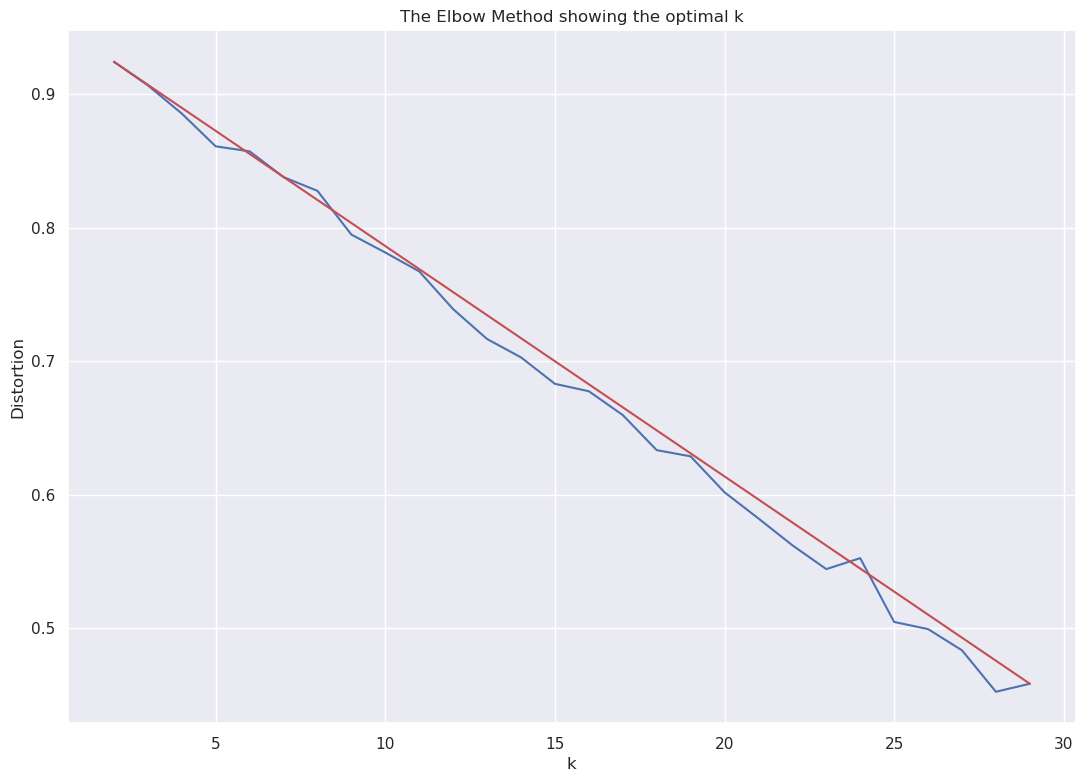

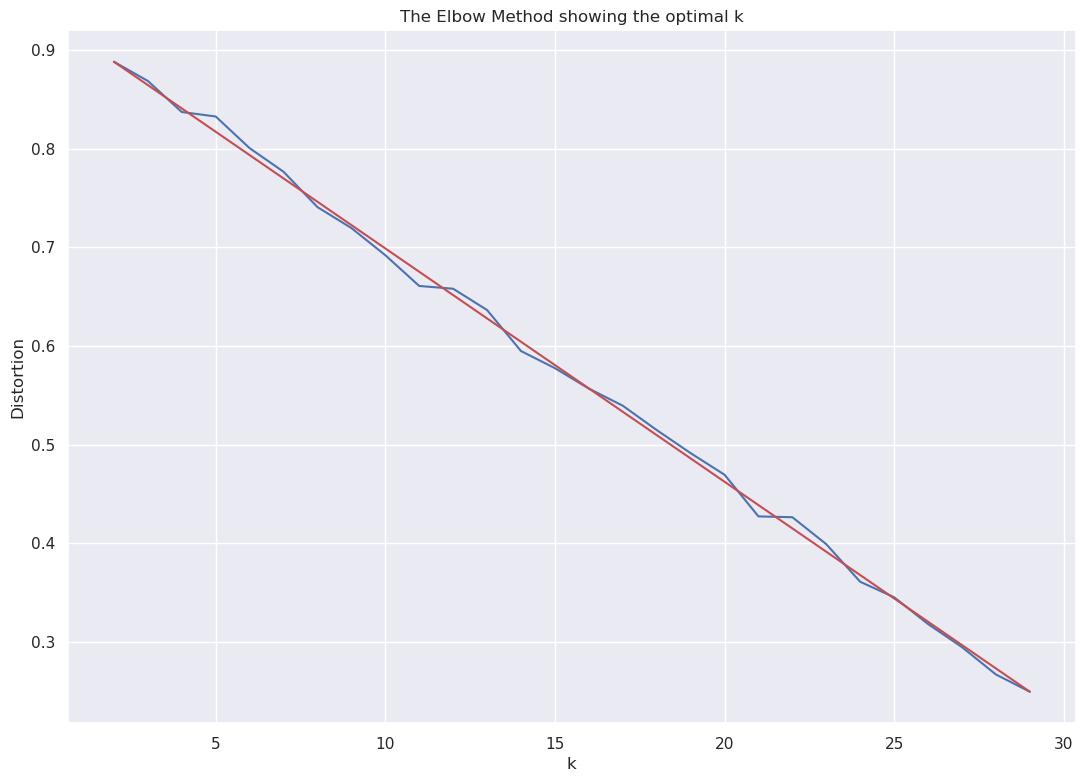

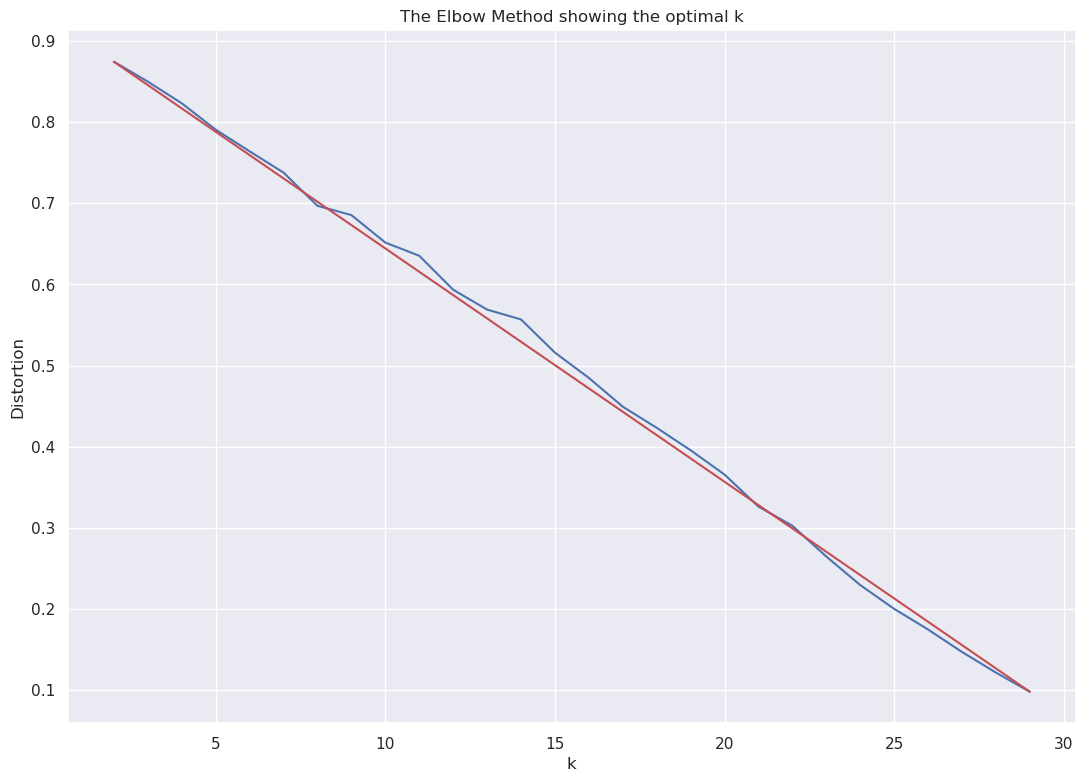

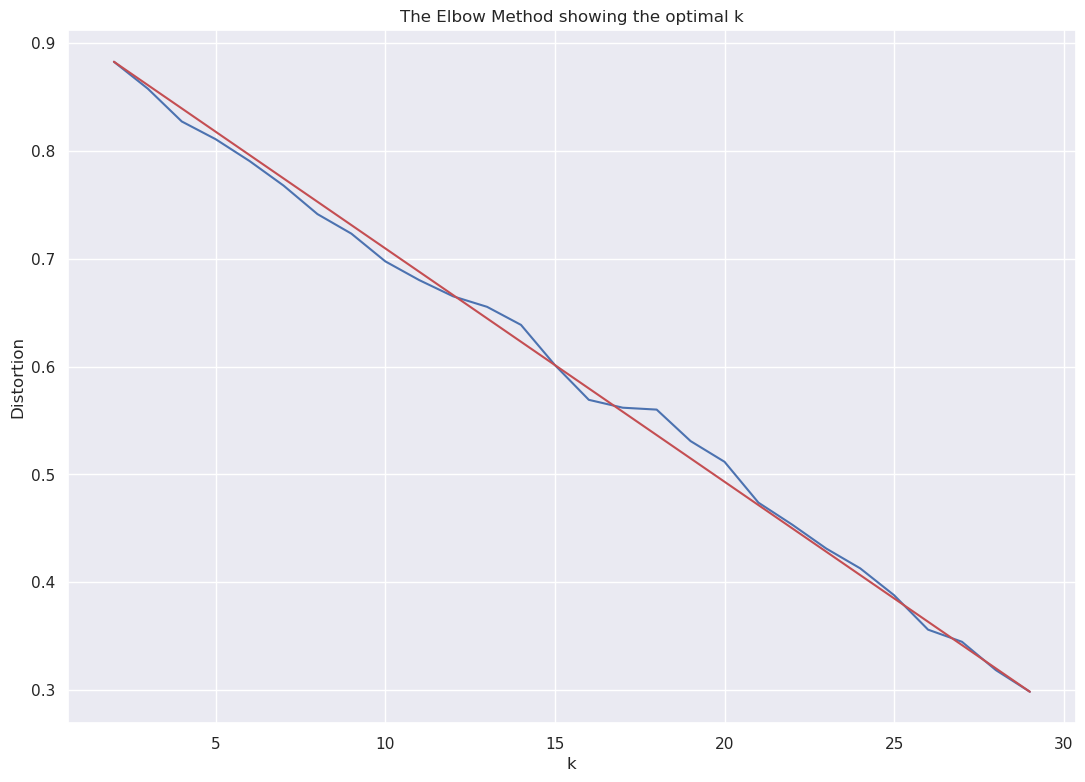

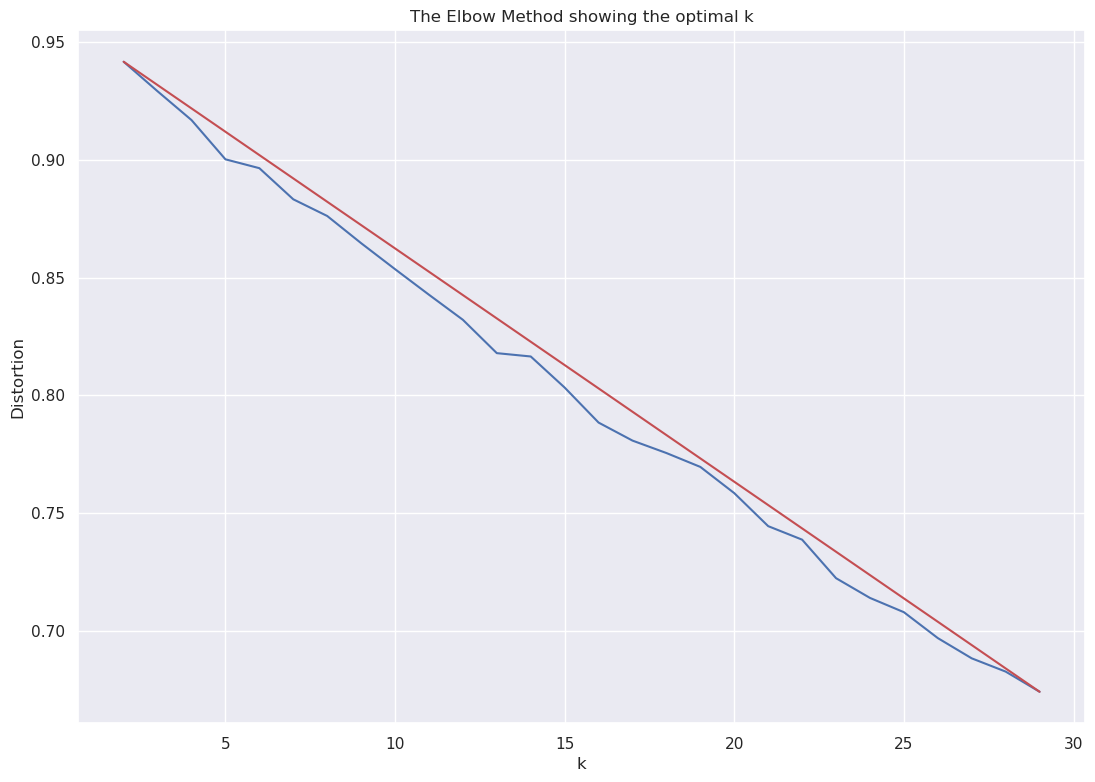


Radcom


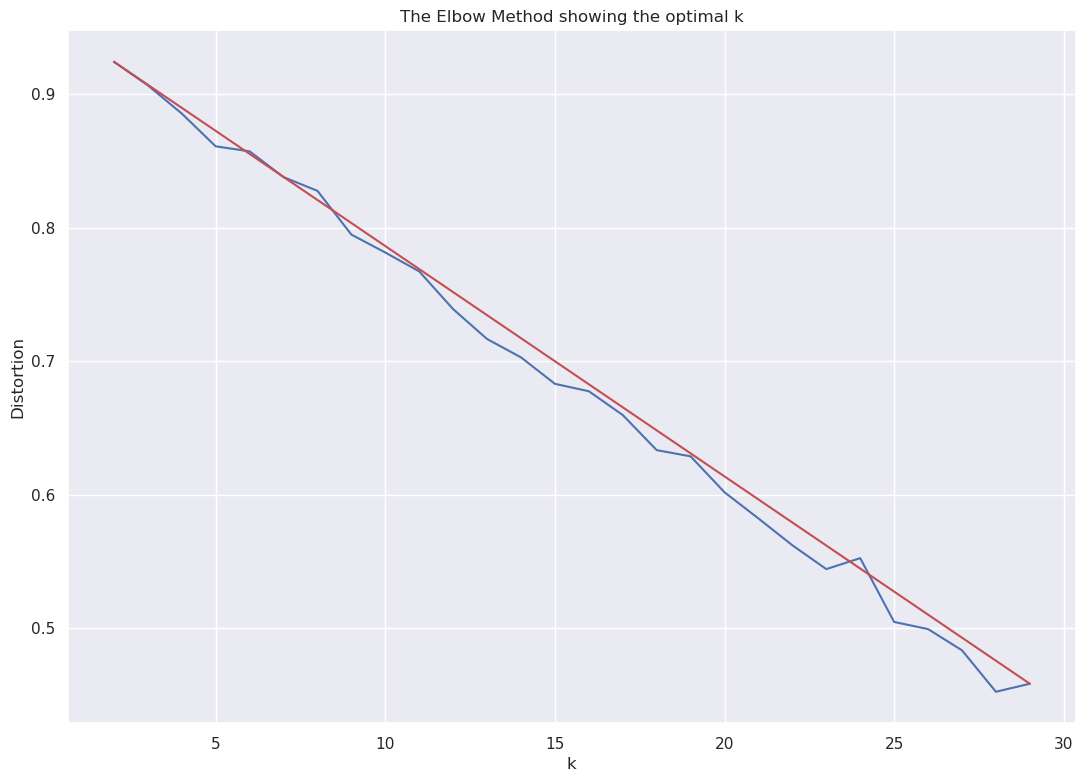

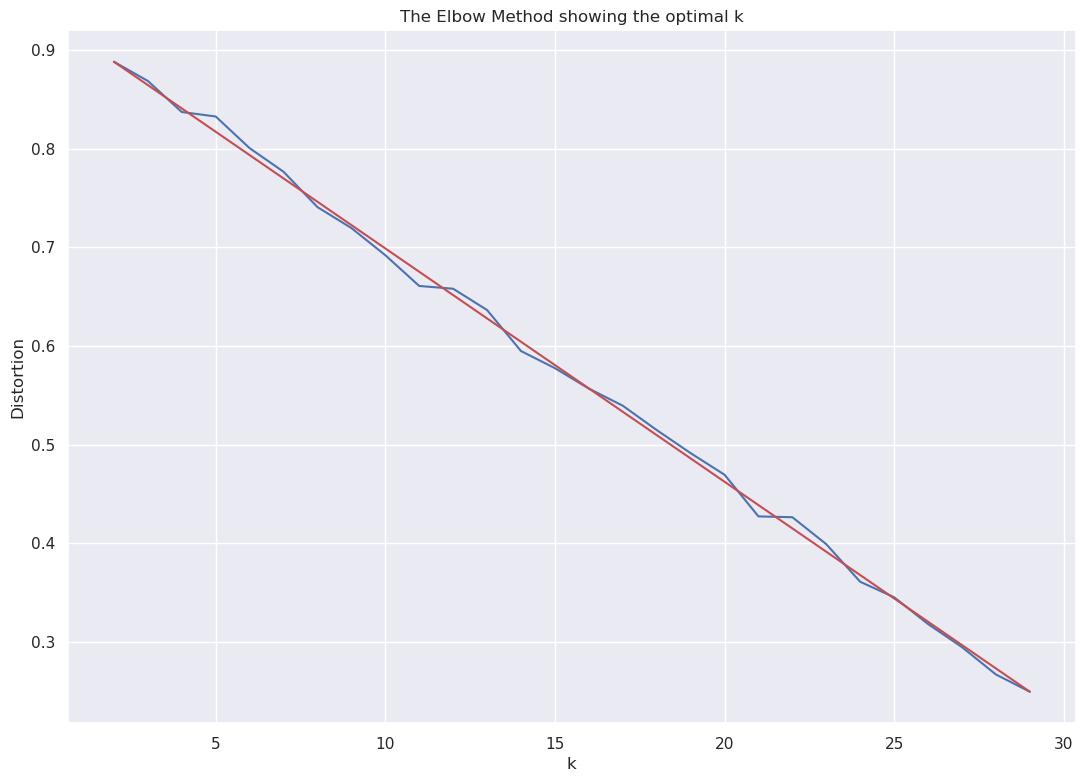

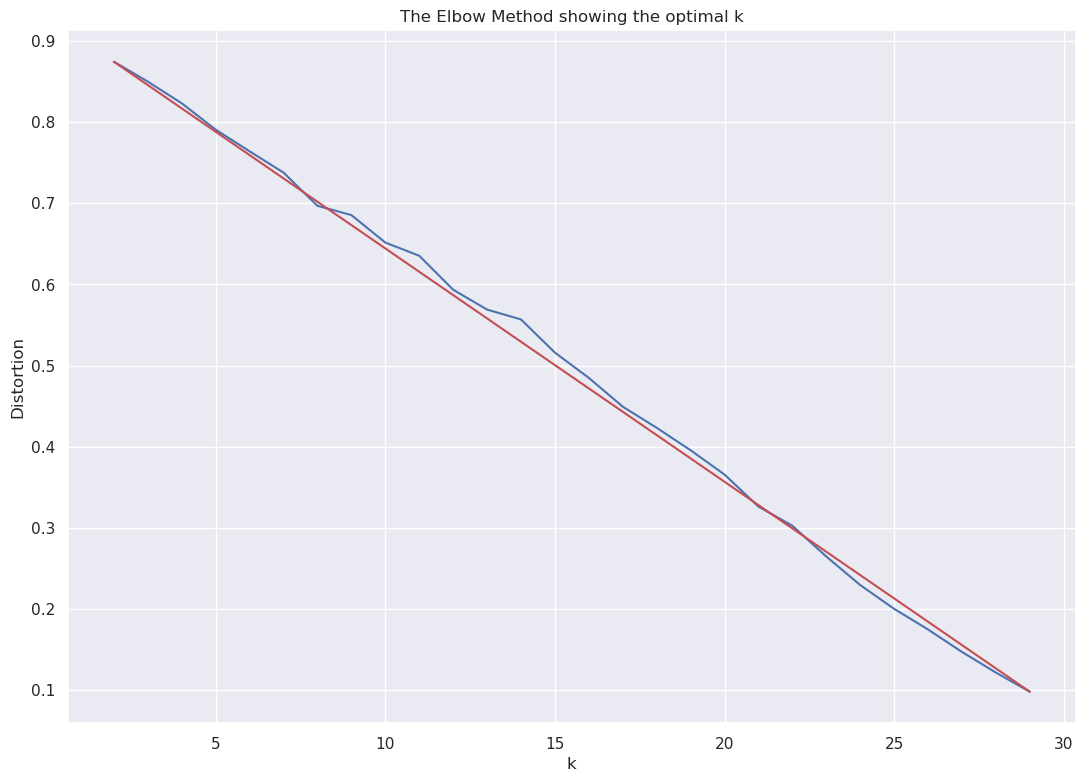

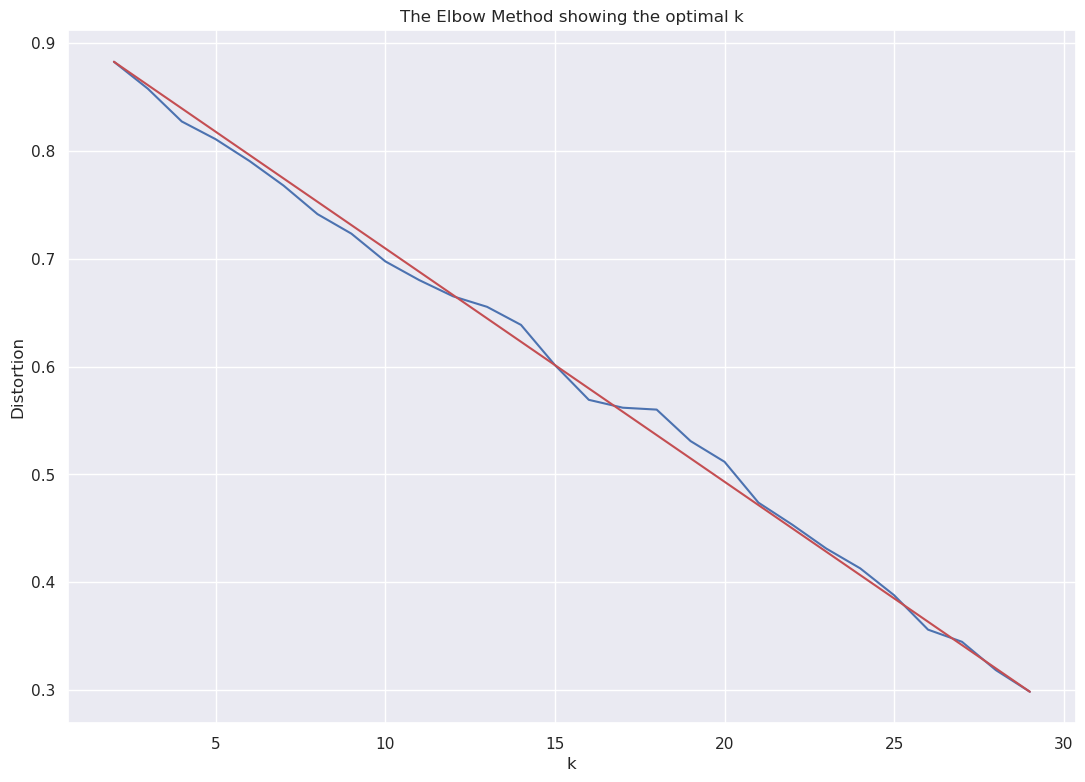

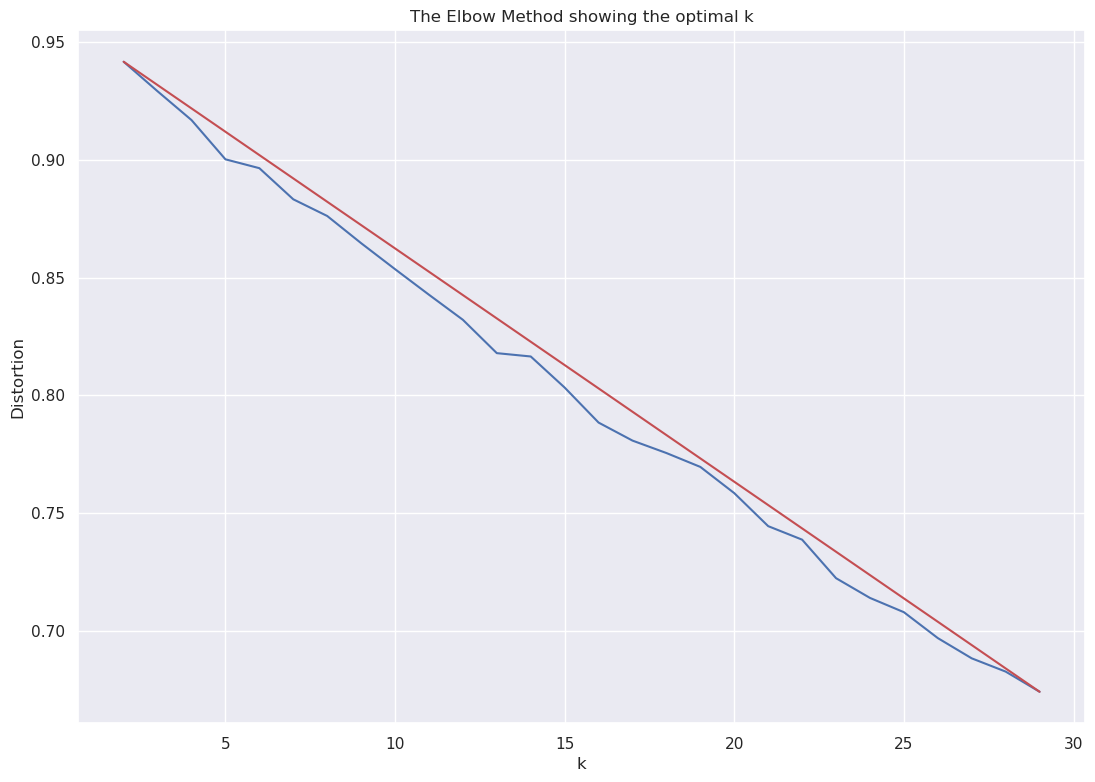

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 66 samples in 0.001s...
[t-SNE] Computed neighbors for 66 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 66 / 66
[t-SNE] Mean sigma: 0.427113
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.087563
[t-SNE] KL divergence after 1000 iterations: 0.347544
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 47 samples in 0.000s...
[t-SNE] Computed neighbors for 47 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 47 / 47
[t-SNE] Mean sigma: 0.390306
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.801346
[t-SNE] KL divergence after 1000 iterations: 0.034840
[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 38 samples in 0.000s...
[t-SNE] Computed neighbors for 38 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 38 / 38
[t-SNE] Mean sigma: 0.445411
[t-SNE] KL divergence after 250 iterations with earl

/tmp/ipykernel_5200/1602358936.py:78: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred, legend='full', palette=palette)


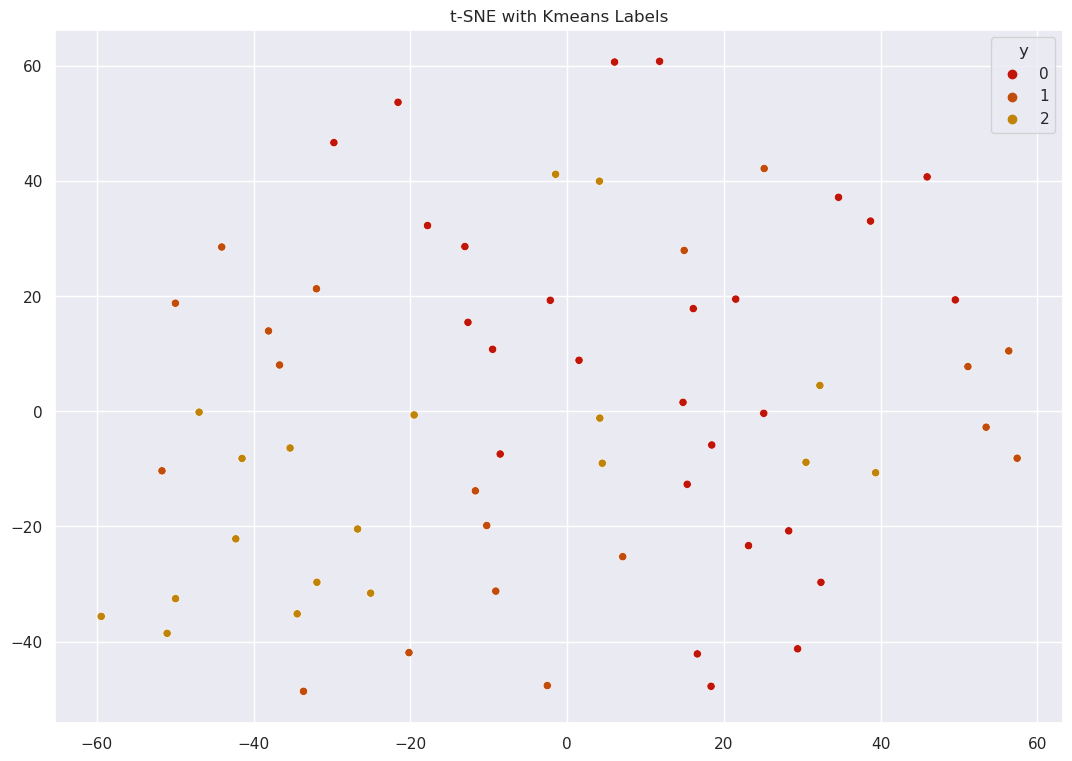

/tmp/ipykernel_5200/1602358936.py:78: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred, legend='full', palette=palette)


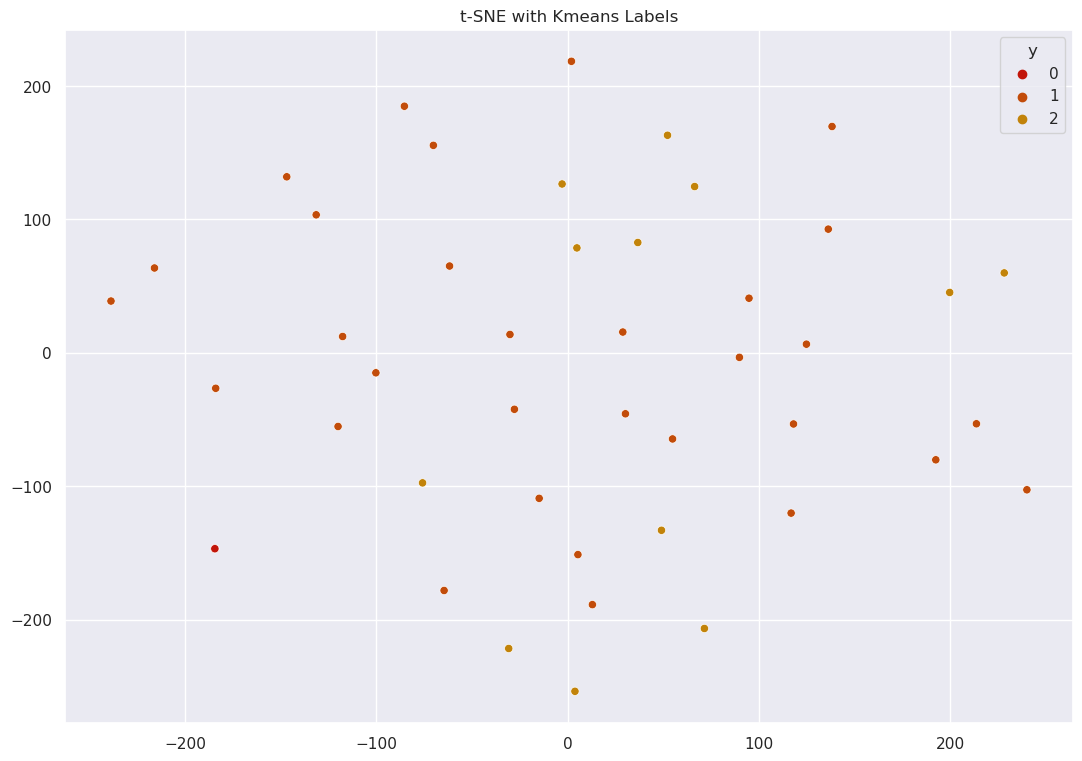

/tmp/ipykernel_5200/1602358936.py:78: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred, legend='full', palette=palette)


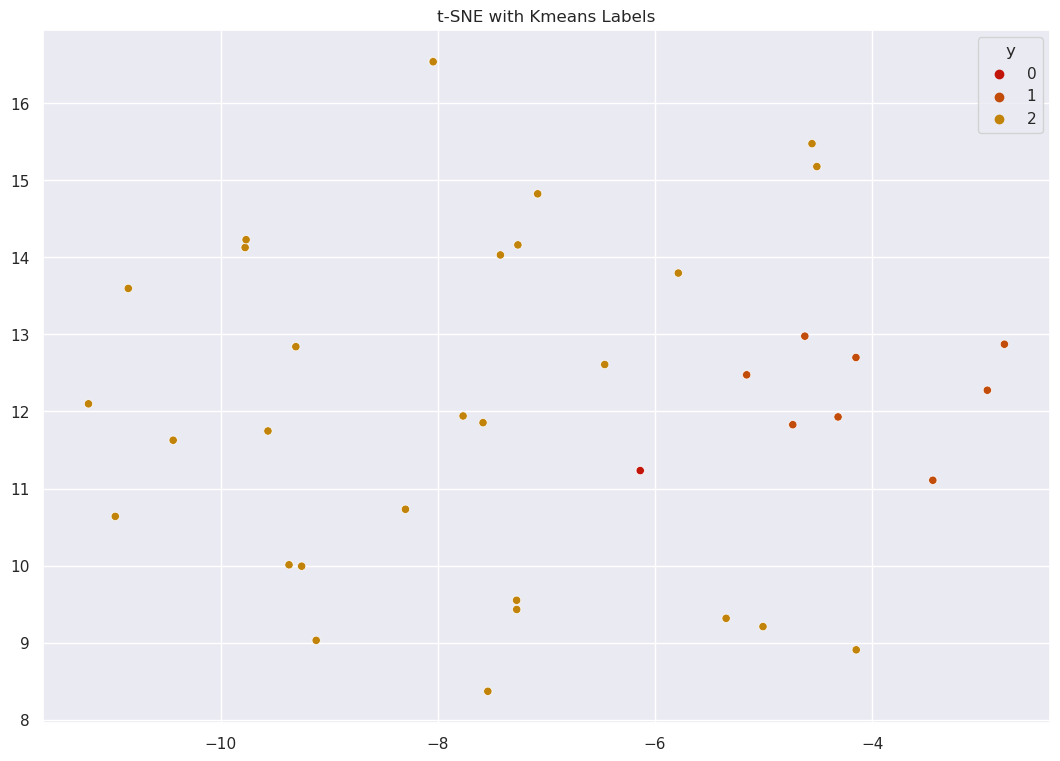

/tmp/ipykernel_5200/1602358936.py:78: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred, legend='full', palette=palette)


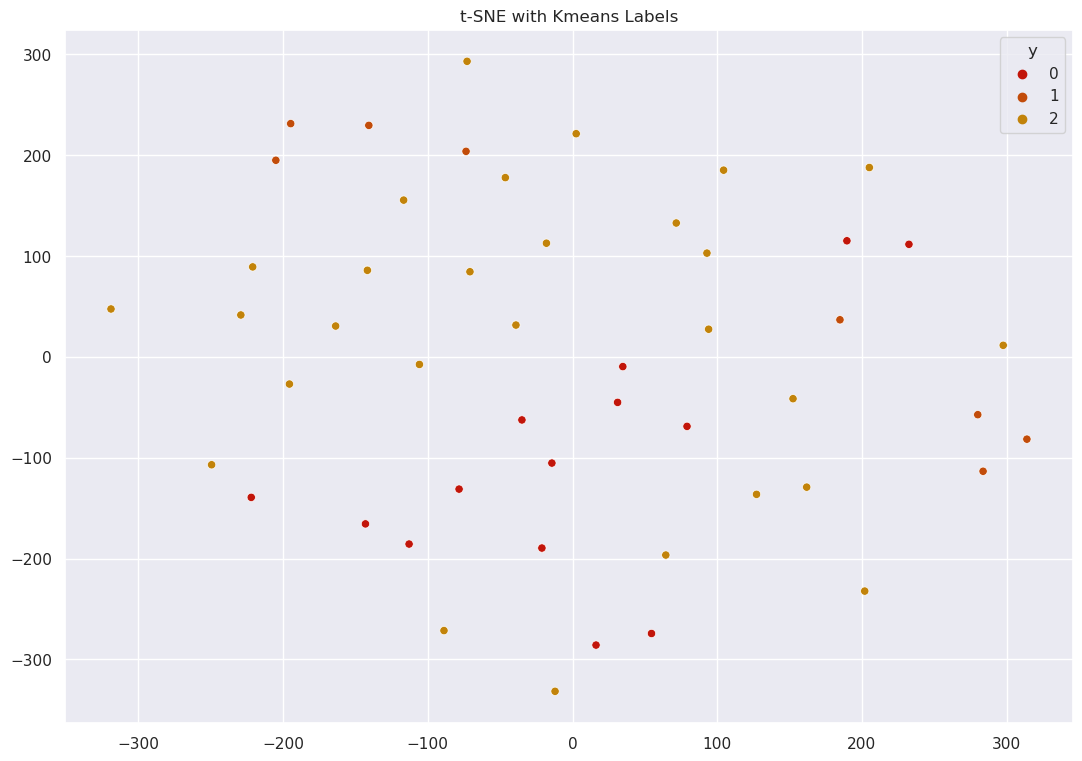

/tmp/ipykernel_5200/1602358936.py:78: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred, legend='full', palette=palette)


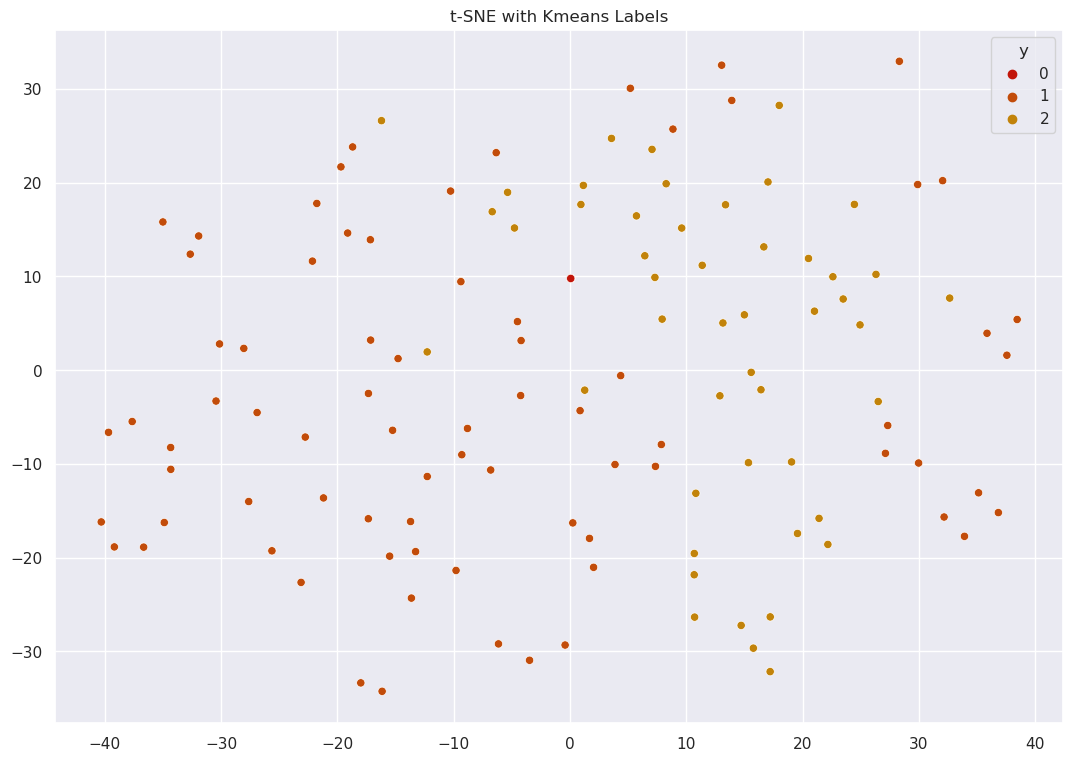


Boost


/tmp/ipykernel_5200/1602358936.py:78: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred, legend='full', palette=palette)


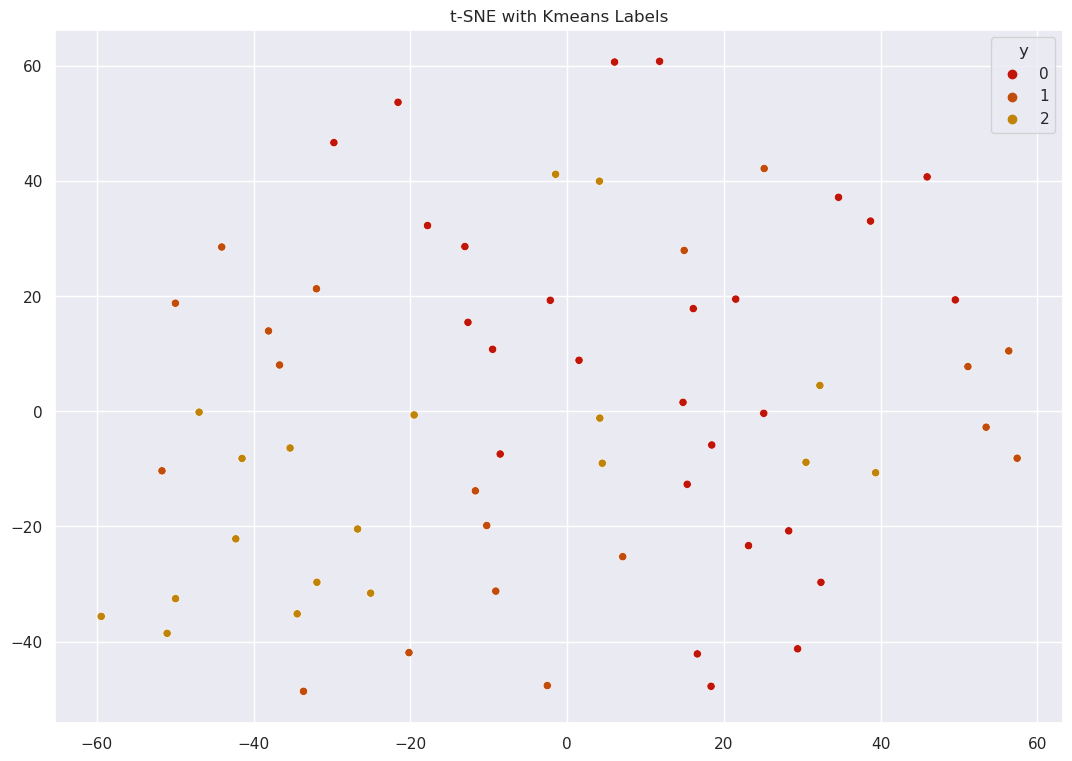

/tmp/ipykernel_5200/1602358936.py:78: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred, legend='full', palette=palette)


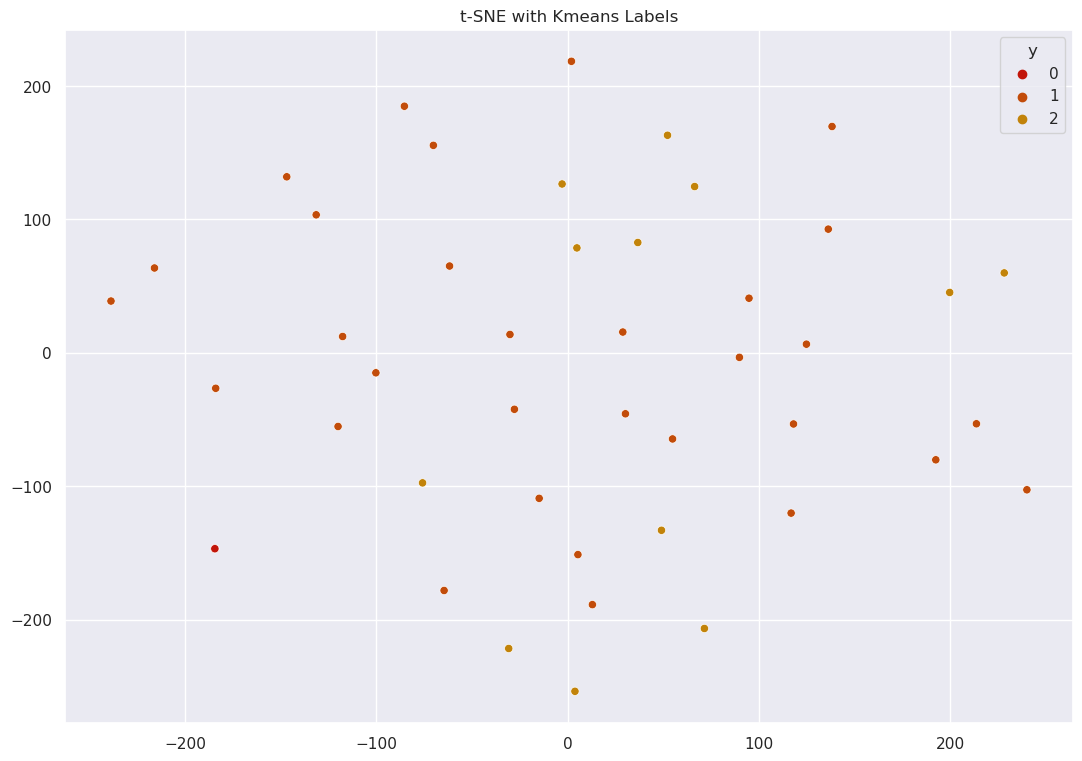

/tmp/ipykernel_5200/1602358936.py:78: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred, legend='full', palette=palette)


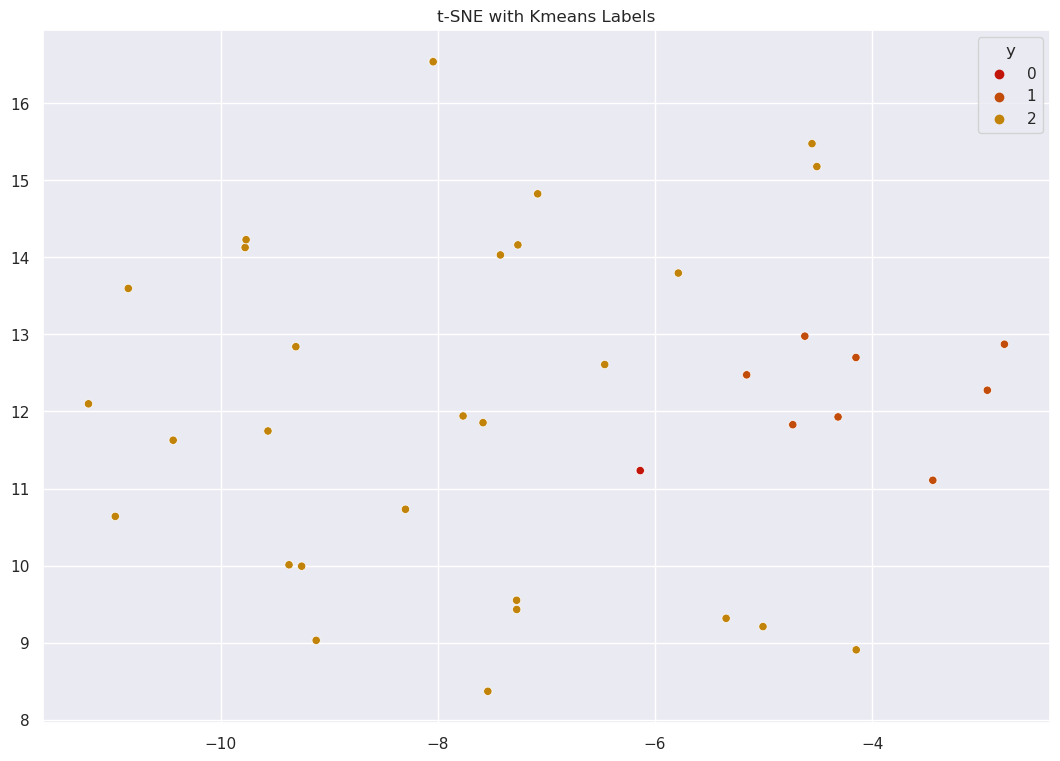

/tmp/ipykernel_5200/1602358936.py:78: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred, legend='full', palette=palette)


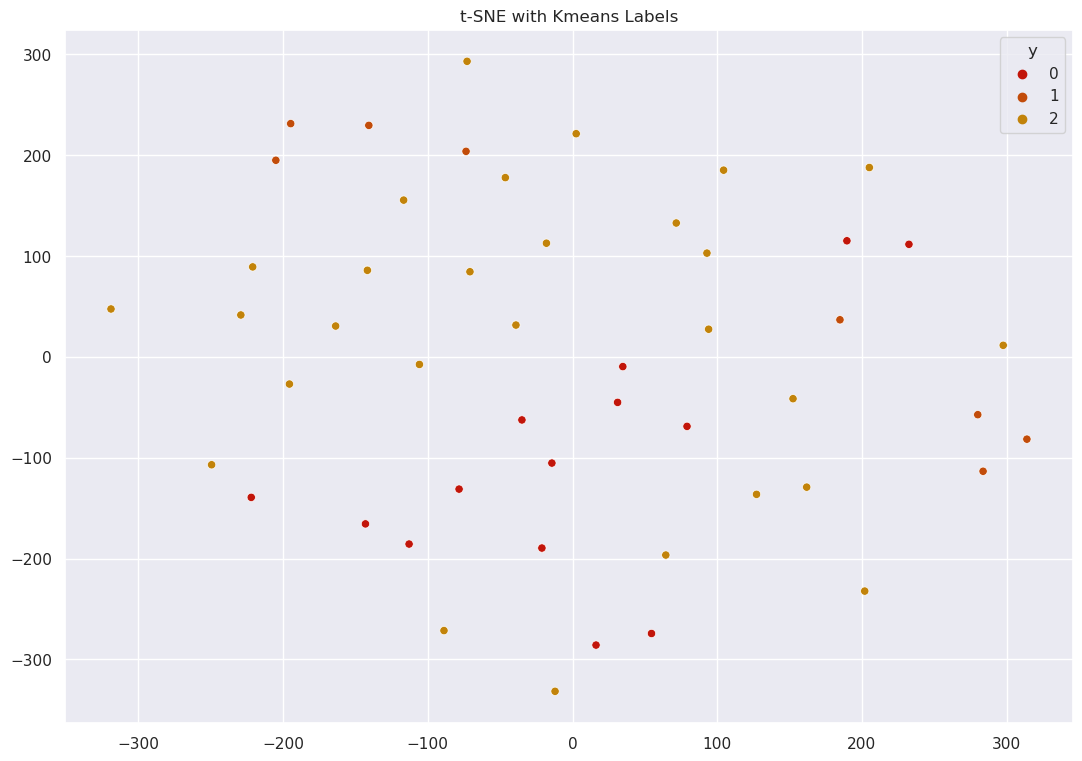

/tmp/ipykernel_5200/1602358936.py:78: UserWarning: The palette list has more values (20) than needed (3), which may not be intended.
  sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred, legend='full', palette=palette)


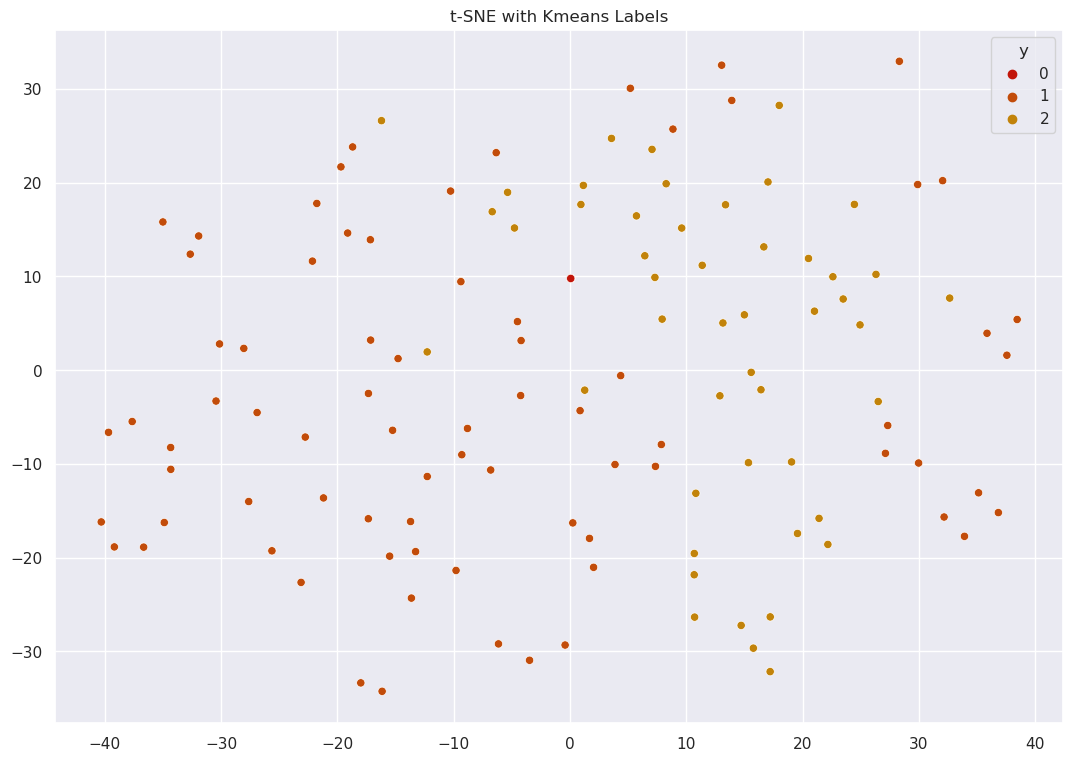

Not enough instances in cluster: 1
Not enough instances in cluster: 0
Not enough instances in cluster: 0
Not enough instances in cluster: 1
Not enough instances in cluster: 0
Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 0
Current Cluster: 1
Current Cluster: 2


,Table_Number,Tags
0,1,"[[streams, address, rtp, number, source], [session]]"
1,2,"[[cdr, session], [table, uses]]"
2,3,"[[configuration, table], [cdr, session]]"
3,4,"[[cdr, session, transaction, type], [based, tcp, enrichment, cdr, table, handset, correlation, plane, traffic, probe, mobile, user, number, configuration, gn-gi]]"
4,5,"[[type, user, diameter, origin, time, session], [destination, signaling, address, number, type, total, src, code]]"


,Table_Number,Tags
0,1,"[[streams, address, rtp, number, source], [session]]"
1,2,"[[cdr, session], [table, uses]]"
2,3,"[[configuration, table], [cdr, session]]"
3,4,"[[cdr, session, transaction, type], [based, tcp, enrichment, cdr, table, handset, correlation, plane, traffic, probe, mobile, user, number, configuration, gn-gi]]"
4,5,"[[type, user, diameter, origin, time, session], [destination, signaling, address, number, type, total, src, code]]"


In [10]:
# Specify the paths to your .xlsx files

#Compile the list of functions for the different steps
functions = [df_header_fixer, df_trunkater, desc_filler, cleaner] 
vectorfuncs= [vectorizer, pcareducer]

#run the final pipeline.  Starts with an s3 location, and a cluster count, outputs tagged dataframe, elbow plots, and kmeans scatterplots
final_pipeline(bucket_name, file_key_radcom, functions, vectorfuncs, 3)